# EECS 16A: Homework 2

## Problem 5: Image Stitching

This section of the notebook continues the image stiching problem. Be sure to have a `figures` folder in the same directory as the notebook. The `figures` folder should contain the files:

    Berkeley_banner_1.jpg
    Berkeley_banner_2.jpg
    stacked_pieces.jpg
    lefthalfpic.jpg
    righthalfpic.jpg
    
Note: This structure is present in the provided HW4 zip file.

Run the next block of code before proceeding


In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi, cos, exp, sin
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms


#%matplotlib inline

#loading images
image1=mpimg.imread('figures/Berkeley_banner_1.jpg')
image1=image1/255.0
image2=mpimg.imread('figures/Berkeley_banner_2.jpg')
image2=image2/255.0
image_stack=mpimg.imread('figures/stacked_pieces.jpg')
image_stack=image_stack/255.0


image1_marked=mpimg.imread('figures/lefthalfpic.jpg')
image1_marked=image1_marked/255.0
image2_marked=mpimg.imread('figures/righthalfpic.jpg')
image2_marked=image2_marked/255.0

def euclidean_transform_2to1(transform_mat,translation,image,position,LL,UL):
    new_position=np.round(transform_mat.dot(position)+translation)
    new_position=new_position.astype(int)

    
    if (new_position>=LL).all() and (new_position<UL).all():
        values=image[new_position[0][0],new_position[1][0],:]
    else:
        values=np.array([2.0,2.0,2.0])
    
    return values

def euclidean_transform_1to2(transform_mat,translation,image,position,LL,UL):
    transform_mat_inv=np.linalg.inv(transform_mat)
    new_position=np.round(transform_mat_inv.dot(position-translation))
    new_position=new_position.astype(int)
    
    if (new_position>=LL).all() and (new_position<UL).all():
        values=image[new_position[0][0],new_position[1][0],:]
    else:
        values=np.array([2.0,2.0,2.0])
    
    return values

We will stick to a simple example and just consider stitching two images (if you can stitch two pictures, then you could conceivably stitch more by applying the same technique over and over again).

Daniel decided to take an amazing picture of the Campanile overlooking the bay. Unfortunately, the field of view of his camera was not large enough to capture the entire scene, so he decided to take two pictues and stich them together. 

The next block will display the two images.

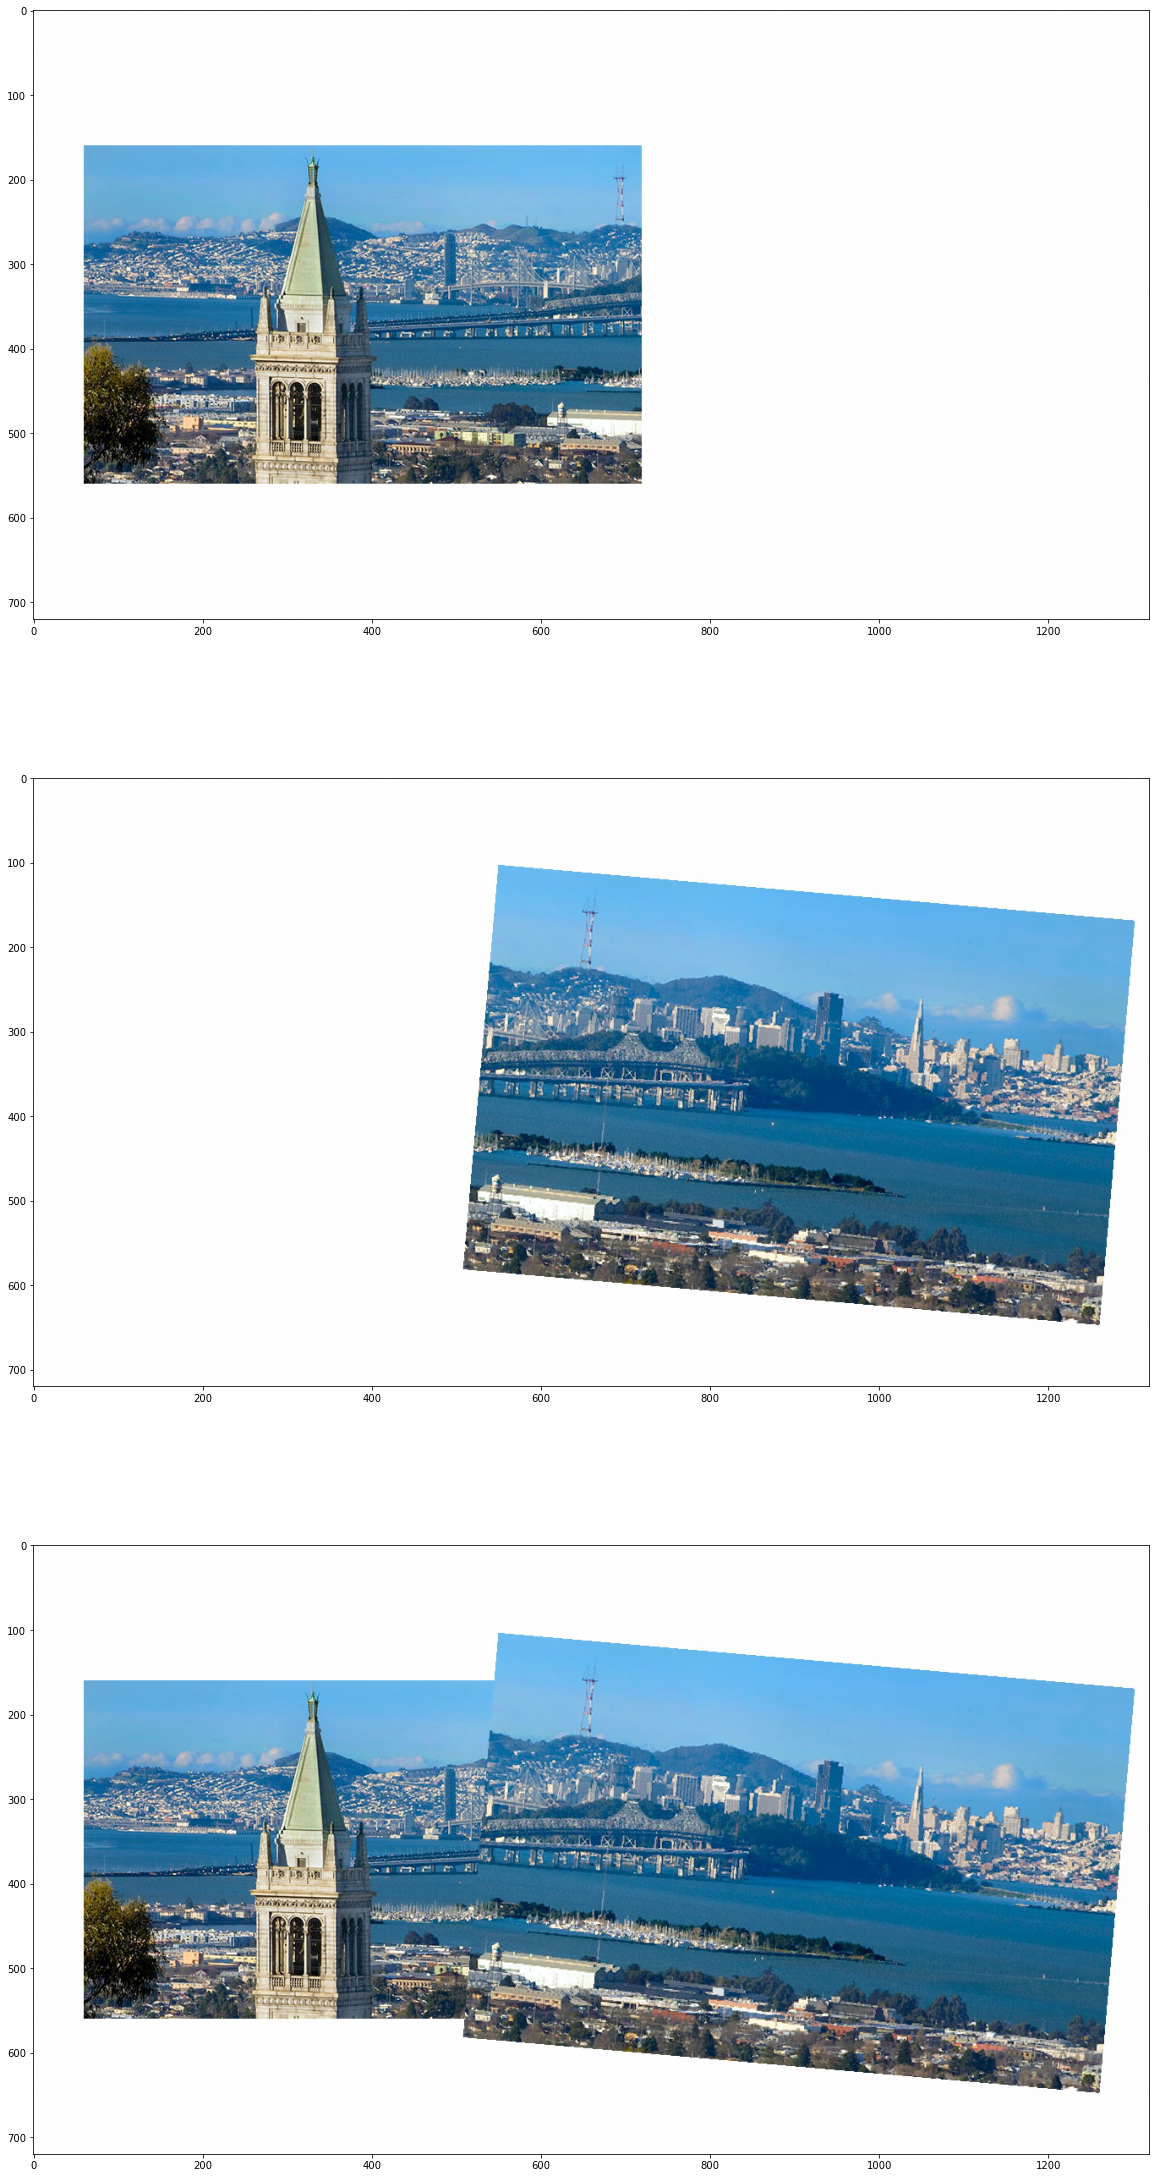

In [2]:
plt.figure(figsize=(20,40))

plt.subplot(311)
plt.imshow(image1)

plt.subplot(312)
plt.imshow(image2)

plt.subplot(313)
plt.imshow(image_stack)

plt.show()

Once you apply Marcela's algorithm on the two images you get the following result (run the next block):

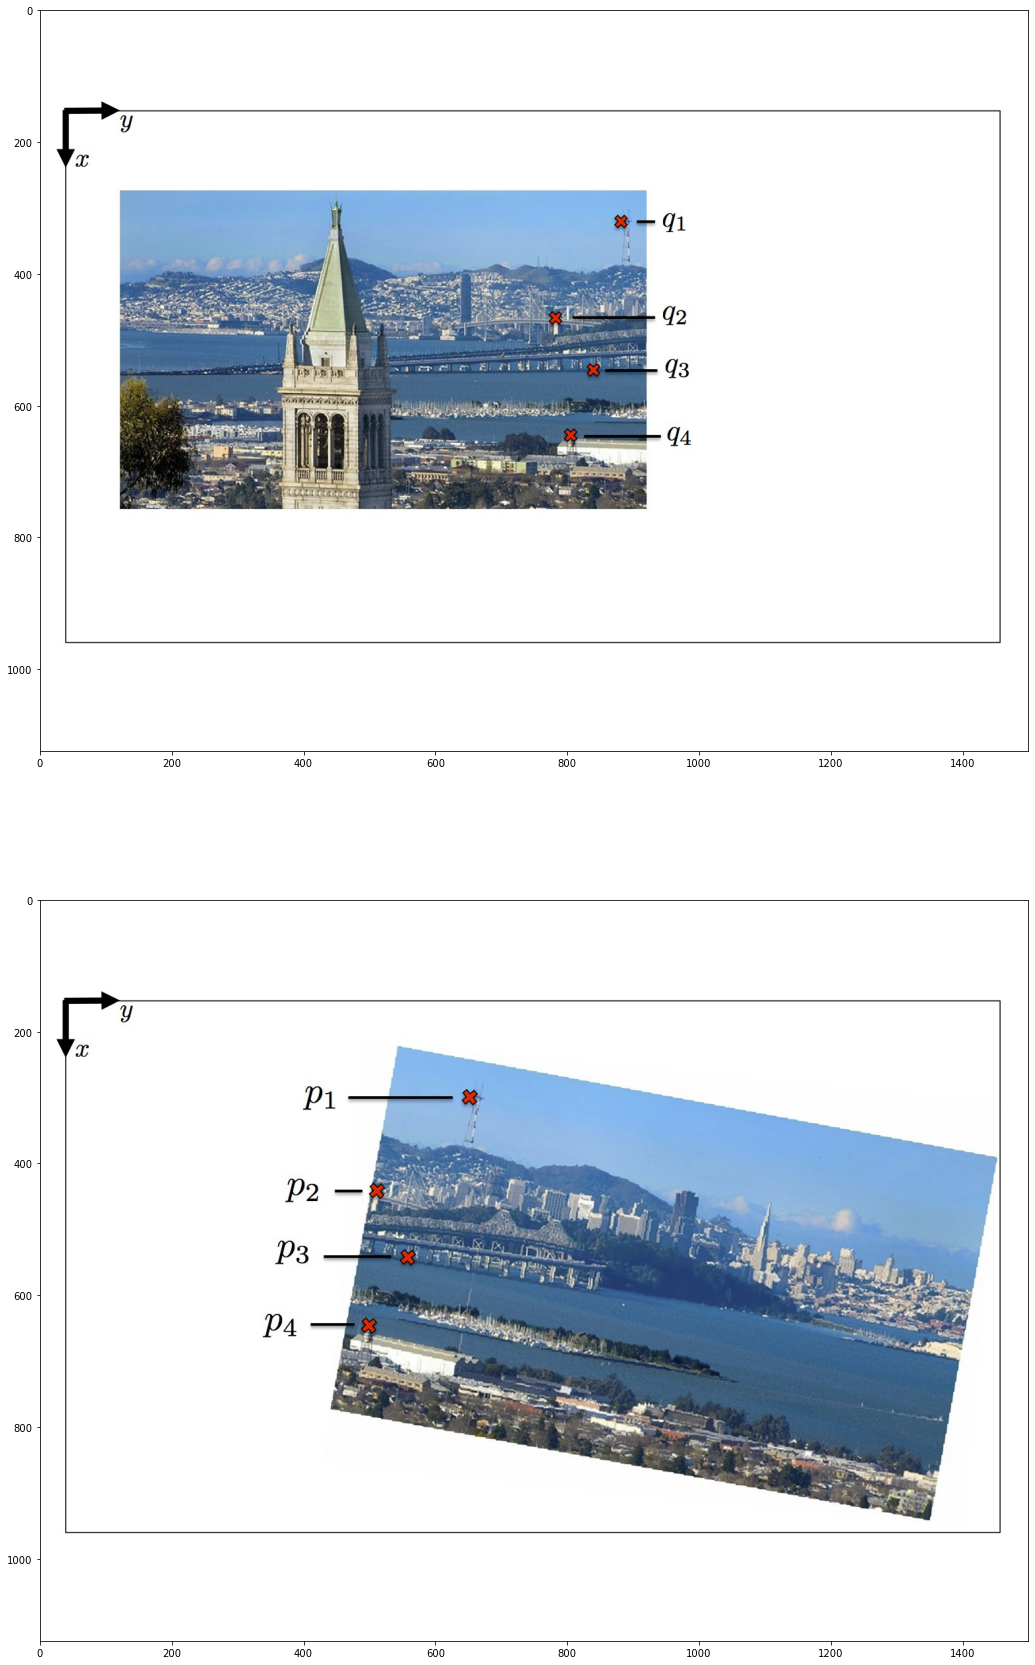

In [4]:
plt.figure(figsize=(20,30))

plt.subplot(211)
plt.imshow(image1_marked)

plt.subplot(212)
plt.imshow(image2_marked)

As you can see Marcela's algorithm was able to find four common points between the two images. These points expressed in the coordinates of the first image and second image are

$\begin{align} 
&&\vec{p_1}=\begin{bmatrix} 200 \\ 700 \end{bmatrix}
&&\vec{p_2}=\begin{bmatrix} 310 \\ 620 \end{bmatrix} 
&&\vec{p_3}=\begin{bmatrix} 390 \\ 660 \end{bmatrix}
&&\vec{p_4}=\begin{bmatrix} 460 \\ 630 \end{bmatrix}\\
&&\vec{q_1}=\begin{bmatrix} 162.2976 \\ 565.8862 \end{bmatrix}
&&\vec{q_2}=\begin{bmatrix} 285.4283 \\ 458.7469 \end{bmatrix} 
&&\vec{q_3}=\begin{bmatrix} 385.2465 \\ 498.1973 \end{bmatrix}
&&\vec{q_4}=\begin{bmatrix} 465.7892 \\ 455.0132 \end{bmatrix}
\end{align}$

It should be noted that in relation to the image the positive x-axis is down and the positive y-axis is right. This will have no bearing as to how you solve the problem, however it helps in interpreting what the numbers mean relative to the image you are seeing.

Using the points determine the parameters $r_{xx},r_{xy},r_{yx},r_{yy},T_x,T_y$ that map the points from the first image to the points in the second image by solving an appropriate system of equations. Hint: you do not need all the points to recover the parameters. 

In [5]:
# Note that the following is a general template for solving for 6 unknowns from 6 equations represented as Az = b.
# You do not have to use the following code exactly. 
# All you need to do is to find parameters r_xx, r_xy, r_yx, r_yy, T_x, T_y. 
# If you prefer finding them another way it is fine.

A = np.array([[200, 700, 0, 0, 1, 0],
              [0, 0, 200, 700, 0, 1 ],
              [310, 620, 0, 0, 1, 0],
              [0, 0, 310, 620, 0, 1 ],
              [460, 630, 0, 0, 1, 0],
              [0, 0, 460, 630, 0, 1 ]])

b = np.array([[162.2976], [565.8862], [285.4283], [458.7469], [465.7892], [455.0132]])

A = A.astype(float)
b = b.astype(float)

# solve the linear system for the coefficiens
z = np.linalg.solve(A,b)

#Parameters for our transformation
r_xx = z[0,0]
r_xy = z[1,0]
r_yx = z[2,0]
r_yy = z[3,0]
T_x  = z[4,0]
T_y  = z[5,0]

Stitch the images using the transformation you found by running the code below.

### Note that it takes about 40 seconds for the block to finish running on a modern laptop.



[[ 1.19543351  0.10458733]
 [-0.10458695  1.1954342 ]]
[-150.00023206 -250.00034962]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


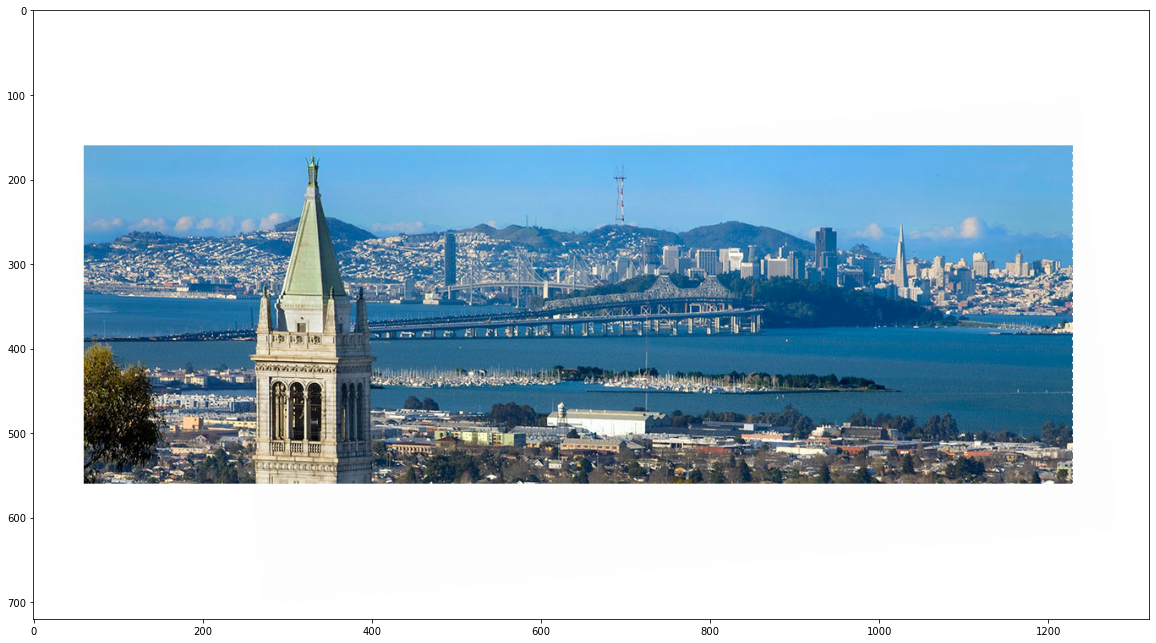

In [5]:
matrix_transform=np.array([[r_xx,r_xy],[r_yx,r_yy]])
translation=np.array([T_x,T_y])
print(matrix_transform)
print(translation)

#Creating image canvas (the image will be constructed on this)
num_row,num_col,blah=image1.shape
image_rec=1.0*np.ones((int(num_row),int(num_col),3))

#Reconstructing the original image

LL=np.array([[0],[0]]) #lower limit on image domain
UL=np.array([[num_row],[num_col]]) #upper limit on image domain

for row in range(0,int(num_row)):
    for col in range(0,int(num_col)):
        #notice that the position is in terms of x and y, so the c  
        position=np.array([[row],[col]])       
        if image1[row,col,0] > 0.995 and image1[row,col,1] > 0.995 and image1[row,col,2] > 0.995:
            temp = euclidean_transform_2to1(matrix_transform,translation,image2,position,LL,UL)
            image_rec[row,col,:] = temp
        else:
            image_rec[row,col,:] = image1[row,col,:]
        

plt.figure(figsize=(20,20))
plt.imshow(image_rec)
plt.axis('on')
plt.show()